In [1]:
# Imports:
import os
import re
import statistics
import pandas as pd
import numpy as np

# Disable FutureWarnings:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
directory_path = os.path.abspath("Processed_Data")
file_list = os.listdir(directory_path)
file_list

['SPACallback-Apr17-Mar18.csv',
 'SPACallback-Apr18-Mar19.csv',
 'SPACallback-Apr19-Mar20.csv',
 'SPACallback-Apr20-Mar21.csv',
 'SPACallback-Apr21-Mar22.csv',
 'SPACallback-Apr22-Mar23.csv',
 'SPACallback-Apr23-Jun23.csv']

In [3]:
def append_csv_files(file_list):
    dfs = []
    for file_name in file_list:
        # Combine directory path and file name:
        file_path = os.path.join(directory_path, file_name)
        # Read each Excel file into a DataFrame:
        single_df = pd.read_csv(file_path)
        # Append the DataFrame to the list:
        dfs.append(single_df)
    # Concatenate all DataFrames in the list:
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [4]:
df = append_csv_files(file_list)

# Remove NaN values from the DataFrame:
df = df.dropna()

# Save the DataFrame as an Excel file:
df.to_csv('Combined_SPA_Callback.csv', index=False)

In [5]:
from sentence_transformers import SentenceTransformer

# Choosing SentenceTransformer model:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Creating embeddings from sentences:
sentences = list(df["Text"])
embeddings = model.encode(sentences)

In [6]:
from sklearn.cluster import AffinityPropagation

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

# Perform Affinity Propogation to create clusters of embeddings:
embedding_cluster = AffinityPropagation(damping=0.55, max_iter=300, preference =-14, random_state=42).fit(embeddings)
no_of_iterations = embedding_cluster.n_iter_
no_of_clusters = len(embedding_cluster.cluster_centers_)
no_of_labels = len(embedding_cluster.labels_)
print("{} Embeddings divided into {} Clusters made in {} Iterations.".format(no_of_labels, no_of_clusters, no_of_iterations))

# Metrics:
chi = calinski_harabasz_score(embeddings, embedding_cluster.labels_)
dbi = davies_bouldin_score(embeddings, embedding_cluster.labels_)
sil = silhouette_score(embeddings, embedding_cluster.labels_)
print("CHI:{}\nDBI:{}\nSil:{}".format(chi, dbi, sil))

11358 Embeddings divided into 52 Clusters made in 164 Iterations.
CHI:64.44546042853989
DBI:4.31372702182739
Sil:0.0189349502325058


In [7]:
from sklearn.manifold import TSNE

# Perform dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

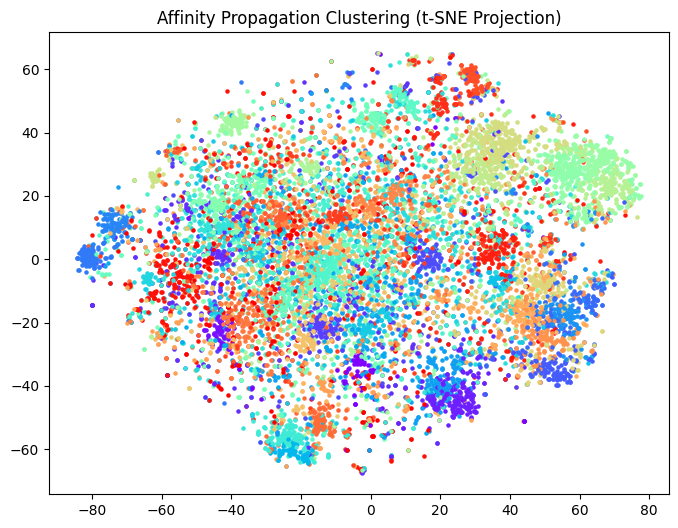

In [8]:
import matplotlib.pyplot as plt

# Visualize the clustering results in 2D:
plt.figure(figsize=(8, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, no_of_clusters))
for i in range(len(embeddings_2d)):
    plt.scatter(embeddings_2d[i][0], embeddings_2d[i][1], color = colors[embedding_cluster.labels_[i]], s=5)

plt.title('Affinity Propagation Clustering (t-SNE Projection)')
plt.show()

In [9]:
# Get the exemplars and their indices:
exemplars_indices = embedding_cluster.cluster_centers_indices_
exemplars = embeddings[exemplars_indices]

In [10]:
# Function to calculate Cosine Distances:
def get_cosine_dist(emb1,emb2):
    cosine_dist = 1 - (np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2)))
    return(cosine_dist)

In [11]:
# Get the cluster labels for the embeddings:
cluster_labels = embedding_cluster.labels_

# Populate indices belonging to each cluster:
cluster_indices = {}
for label in range(no_of_clusters):
    cluster_indices[label] = np.where(cluster_labels == label)[0]

In [12]:
# Find average cosine distance of embeddings within each cluster:
cosdist_list = []
for label, indices in cluster_indices.items():
    cluster_cosdist = []
    exemplar = exemplars[label]
    for index in indices:
        if index not in exemplars_indices:
            cluster_embedding = embeddings[index]
            cluster_cosdist.append(round(get_cosine_dist(exemplar, cluster_embedding),4))
    cosdist_dict={"Average":statistics.mean(cluster_cosdist),
                  "Minimum":min(cluster_cosdist),
                  "Maximum":max(cluster_cosdist)}
    cosdist_list.append(cosdist_dict)
    
# Print the result as a dataframe:
cosdist_df = pd.DataFrame(cosdist_list)
cosdist_df

,Average,Minimum,Maximum
0,0.394303,0.0677,0.7335
1,0.368461,0.1120,0.6935
2,0.335807,0.1106,0.7473
3,0.407578,0.1887,0.7148
4,0.397961,0.2075,0.6697
5,0.392207,0.1918,0.6558
6,0.322386,0.0922,0.7668
7,0.381160,0.2240,0.5823
8,0.411939,0.1674,0.7528
9,0.451573,0.2683,0.6416


In [13]:
# Find average cosine distance of exemplars within each cluster:
exemplar_list = []
for exemplar1 in exemplars:
    exemplar_cosdist = []
    for exemplar2 in exemplars:
        if np.all(exemplar1!=exemplar2):
            exemplar_cosdist.append(round(get_cosine_dist(exemplar1, exemplar2),4))
    exemplar_dict={"Average":statistics.mean(exemplar_cosdist),
                   "Minimum":min(exemplar_cosdist),
                   "Maximum":max(exemplar_cosdist)}
    exemplar_list.append(exemplar_dict)
    
# Print the result as a dataframe:
exemplar_df = pd.DataFrame(exemplar_list)
exemplar_df

,Average,Minimum,Maximum
0,0.592994,0.3666,0.8684
1,0.683796,0.5042,0.8606
2,0.646980,0.3396,0.8106
3,0.554512,0.3011,0.8565
4,0.551827,0.3041,0.8084
5,0.518518,0.3265,0.8071
6,0.665961,0.3273,0.8523
7,0.615716,0.3122,0.7501
8,0.683355,0.5025,0.8610
9,0.657414,0.4518,0.8688


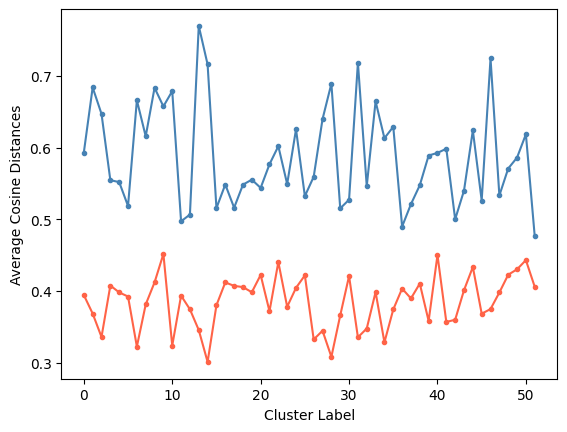

In [14]:
x1 = cosdist_df['Average']
x2 = exemplar_df['Average']

# Plotting the line graph
plt.plot(x1, marker='.',color="tomato", linestyle='-')
plt.plot(x2, marker='.',color="steelblue", linestyle='-')


# Adding labels and title:
plt.xlabel('Cluster Label')
plt.ylabel('Average Cosine Distances')

# Display plot:
plt.show()

In [15]:
df["Cluster"] = cluster_labels

# Save the DataFrame as a CSV file:
df.to_csv('Clustering_Results.csv', index=False)
df

,Date,ID,Text,Cluster
0,26-Jul-17,1.010040e+11,please call daughter Dianne Thomas 07920 07565...,18
1,28-Jul-17,1.010040e+11,please speak to sister - Alyson Powell on abpv...,2
2,28-Jul-17,1.010040e+11,KELLY HAS RUNG - HER PARENTS ARE DUE TO HAVE W...,42
3,31-Jul-17,1.010040e+11,"Mark Hitchings, Scheme Manager Swn Yr Afon con...",40
4,28-Jul-17,1.010040e+11,SON BRIAN HASFORD RUN G- HE IS RESIDENT IN AUS...,43
...,...,...,...,...
11362,13-Jun-23,1.010000e+11,"Enquiring about a downstairs toilet, states he...",49
11363,13-Jun-23,1.010000e+11,Phoning on behalf on her mother she has no fee...,42
11364,13-Jun-23,1.010000e+11,States on saturday they had to call an ambulan...,38
11365,13-Jun-23,1.010000e+11,Nadia Obaji daughter of Abdel Obaji contacted ...,37


In [16]:
# Perform dimensionality reduction with t-SNE
tsne = TSNE(n_components=3, init='pca', random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

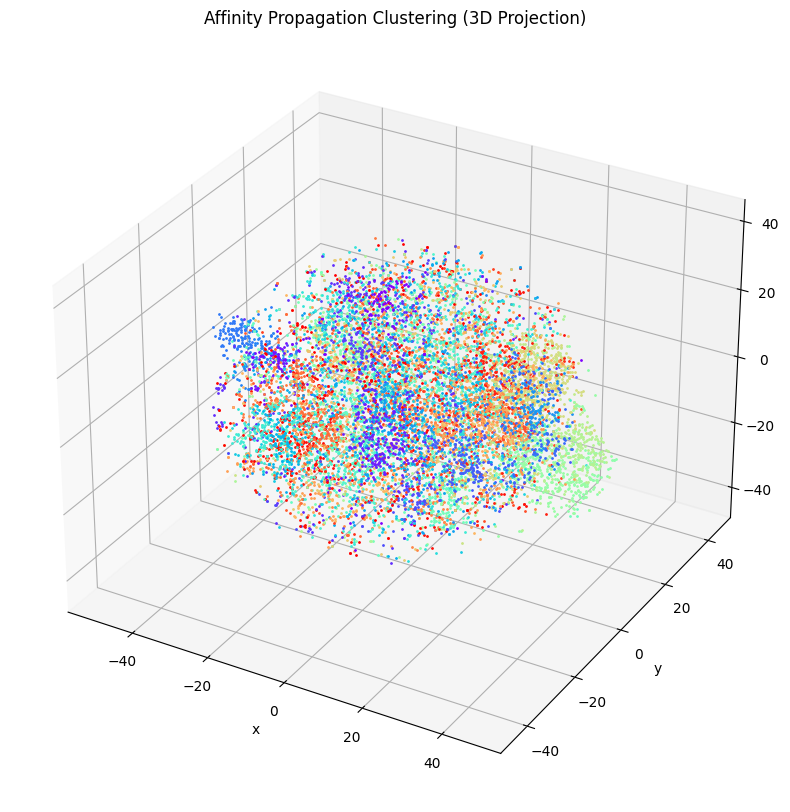

In [17]:
# Visualize the clustering results in 3D:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(embeddings_3d)):
    ax.scatter(embeddings_3d[i][0],embeddings_3d[i][1],embeddings_3d[i][2], color = colors[embedding_cluster.labels_[i]], s=1)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')

plt.title('Affinity Propagation Clustering (3D Projection)')
plt.show()

In [18]:
# Function to clean text for TF-IDF:
def clean_text_for_TFIDF(text):
    # Remove start/trailing spaces:
    text = text.strip()
    # Remove newline characters:
    text = re.sub(r'[\n\r]+', '. ',text)
    # Only keep Alphabets, Digits and Spaces:
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to Lowercase:
    text = text.lower()
    return text

sentence_cluster = list(df[df["Cluster"]==2]["Text"].apply(clean_text_for_TFIDF))

In [19]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Custom stop words to add
my_stop_words = ['mr','mrs','contact','urgent']
custom_stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

for cluster_label in range(no_of_clusters):
    # Clean sentences by cluster and group them as a list:
    sentence_cluster = list(df[df["Cluster"]==cluster_label]["Text"].apply(clean_text_for_TFIDF))

    # Create a Document-Term Matrix
    vectorizer = TfidfVectorizer(stop_words=custom_stop_words)
    X = vectorizer.fit_transform(sentence_cluster)

    # Calculate the TF-IDF scores for the document-term matrix:
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X)

    # Convert the TF-IDF matrix to an array:
    X_tfidf_array = X_tfidf.toarray()

    # Rank Keywords for each sentence:
    top_keywords_per_sentence = []
    for i, sentence in enumerate(sentence_cluster):
        tfidf_scores = [(word, score) for word, score in zip(vectorizer.get_feature_names(), X[i].toarray()[0])]
        tfidf_scores.sort(key=lambda x: x[1], reverse=True)
        top_keywords_per_sentence.append(tfidf_scores)

    # Aggregate and Select Top Keywords:
    all_keywords = {}
    for keywords in top_keywords_per_sentence:
        for keyword, score in keywords:
            if keyword in all_keywords:
                all_keywords[keyword] += score
            else:
                all_keywords[keyword] = score

    # Select the top N keywords:
    top_n_keywords = sorted(all_keywords.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\nCluster Label: {}".format(cluster_label))
    for keyword,score in top_n_keywords:
        print("    {} : {}".format(keyword,round(score,2)))


Cluster Label: 0
    assessment : 15.2
    carers : 11.8
    like : 7.72
    care : 7.31
    test : 5.0

Cluster Label: 1
    like : 9.13
    worker : 9.06
    social : 8.91
    looking : 3.82
    thanks : 3.79

Cluster Label: 2
    equipment : 28.76
    aids : 28.69
    assessment : 27.42
    request : 9.88
    like : 8.22

Cluster Label: 3
    davies : 13.85
    sally : 9.98
    care : 9.92
    request : 8.62
    like : 8.31

Cluster Label: 4
    assessment : 9.77
    dementia : 8.91
    support : 7.84
    daughter : 7.79
    care : 6.63

Cluster Label: 5
    assessment : 15.2
    mobility : 13.73
    tcall : 12.53
    thanks : 12.33
    michelle : 12.28

Cluster Label: 6
    bathing : 27.7
    assessment : 27.01
    request : 10.64
    difficulties : 10.59
    bath : 6.95

Cluster Label: 7
    shower : 13.4
    assessment : 9.22
    seat : 8.37
    chair : 8.05
    bath : 6.63

Cluster Label: 8
    medication : 9.08
    needs : 7.24
    prescription : 7.1
    pharmacy : 6.07
    to

In [20]:
def keep_first_unique(labels):
    seen = set()
    unique = []
    for item in labels:
        if item not in seen:
            unique.append(item)
            seen.add(item)
    return unique

unique_cluster_labels = keep_first_unique(cluster_labels)

cluster_to_exemplar = {}
for label, exemplar_idx in zip(unique_cluster_labels, exemplars_indices):
    cluster_to_exemplar[label] = exemplar_idx
    
# Now you can access exemplar indices for each cluster label:
sorted_cluster_to_exemplar = {k:cluster_to_exemplar[k] for k in sorted(cluster_to_exemplar)}
for label, exemplar_idx in sorted_cluster_to_exemplar.items():
    print("Cluster {} \nExemplar: {}\n".format(label,df["Text"][exemplar_idx]))

Cluster 0 
Exemplar: MRS LLEWELLYN HAS RECENTLY BEEN FITTED WITH A PACE MAKER AFTER FEELING UNWELL - DAUGHTER ASKED IF WE CAN ARRANGE AN URGENT ASSESSMENT AS SHE CANNOT CLIMB THE STAIRS AT THE MOMENT AS ONLY HANDRAIL ONE SIDE 

Cluster 1 
Exemplar: CALLING IN REGARDS TO HER ESTRANGED FATHER IN LAW - STATED THEY HAVENT SPOKEN FOR OVER A YEAR - BUT HE HAS TURNED UP TO THE HOUSE TODAY STATING HE COULDNT GET INTO HIS PROPERTY AND ACCUSING HIS SON OF TAMPERING WITH THE DOOR - THERE HAS BEEN AN NUMBER OF INCIDENTS WHERE HE ACCUSED THEM OF HIDING MEDICATION - STATES SHE THINKS THERE IS A DIAGNOSIS OF DIMENTIA - SHE IS CONCERNED ABOUT HIS WELFARE AND ALSO CONTACTED THE POLICE TODAY TO A WELFARE CHECK BUT THEY STATED AS HE WAS WITH A NEIGHBOUR THEY WERENT OVERLY CONCERNED - STATES HE LIVES ALONE - PLEASE CAN WE CONTACT BACK AND ADVISE FURTHER FOR AN ASSESSMENT. 

Cluster 2 
Exemplar: Please contact Lynne Williams 01443672736 sister of client, Mrs Margaret Davies is requesting a stairlift.

Clus